
**42186 Model-Based machine learning**



**Authors:**

Matteo D'Souza - s242947

Ulrik Longva Haugland - s241658

Giovanni Fassoni - s242942

Florian Schwill - s250424


## Table of contents

1. [Motivation](#motivation)  
2. [Data Exploration](#data-exploration)  
3. [ Bayesian Linear Regression](#variational-inference-and-bayesian-linear-regression)  
4. [Probabilistic Graphical Model](#probabilistic-graphical-model)  
5. [Hierarchical Modeling](#hierarchical-modeling)    
6. [Contribution](#contribution)  
7. [References](#references)


## Structure of the Notebook

In the ***Motivation*** section, we introduce the dataset, explain why it was chosen, and outline the end goal of the project. This includes briefly some context of the problem.

In the ***Data Exploration*** section, we perform an initial inspection of the dataset. This includes data cleaning, preprocessing, and basic descriptive statistics to better understand the data distribution of the dataset's features.

In the ***Bayesian Linear Regression*** section, use a Bayesian Linear Regression as a first approach to predict the deliver's duration.

In the ***Probabilistic Graphical Model*** section, we present the conceptual model used to represent dependencies in the data. We define the variables, describe their relationships, and explain how the model would captures uncertainty and structure.

In the ***Hierarchical Modeling*** section, we introduce multilevel modeling to account for group-level variations. We implement hierarchical models to predict the target.

In the ***Contribution*** section, we clarify who contributed to each part of the project. This includes not only the individual contributions for the self-explanatory notebook but also for the final report.

In the ***References*** section, we provide and mention sources to support specific concepts or methodological choices that require justification or external validation.


##Part 1:Motivation

We have chosen a dataset containing information about food deliveries in India. The dataset consists of data such as weekday, time of day, weather, start/destination of order and what kind of vehicle the driver had. Our goal is to have an accurate prediction of delivery times, as this is essential for optimizing logistics in food delivery systems. It enables efficient resource allocation, improves real-time scheduling, and provides a basis for evaluating driver performance.

##Part 2: Data Exploration



**Libraries**

In [1]:
!pip install pyro-ppl


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import torch
import itertools
import math

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam
from pyro.nn import PyroModule
from pyro.infer.autoguide import AutoNormal
import pyro.optim as optim


# Fix random seed for reproducibility
np.random.seed(42)
pyro.set_rng_seed(42)

# Matplotlib and Seaborn settings
palette = itertools.cycle(sns.color_palette())
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (16, 10)
%matplotlib inline


**Loading the dataset and getting first basic information about it**

In [4]:
df=pd.read_csv('food_delivery_data.csv')
df.head()
#Removing column representing the index of the row
df.drop(['Unnamed: 0'], inplace=True, axis=1)
df

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,0xd224,DEHRES11DEL03,21.0,4.9,0.000000,0.000000,0.060000,0.060000,15-02-2022,21:35:00,21:45:00,Sunny,Jam,2.0,Buffet,motorcycle,0.0,No,Urban,17.0
1,0x30d6,RANCHIRES18DEL02,23.0,4.8,23.351489,85.324253,23.371489,85.344253,05-04-2022,10:55:00,11:05:00,Sunny,Low,2.0,Drinks,electric_scooter,1.0,No,Urban,22.0
2,0x8f18,INDORES18DEL02,39.0,4.6,22.753839,75.897429,22.833838,75.977429,31-03-2022,17:15:00,17:20:00,Windy,Medium,0.0,Drinks,motorcycle,0.0,No,Metropolitian,32.0
3,0xdbd2,KOCRES02DEL03,23.0,4.5,10.028047,76.310019,10.088047,76.370019,15-02-2022,21:50:00,22:00:00,Sandstorms,Jam,2.0,Meal,scooter,1.0,No,Metropolitian,22.0
4,0x129b,VADRES08DEL01,31.0,4.2,0.000000,0.000000,0.040000,0.040000,15-03-2022,14:15:00,14:20:00,Windy,High,0.0,Buffet,motorcycle,2.0,No,Urban,41.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37226,0x799d,INDORES14DEL02,39.0,4.4,22.761593,75.886362,22.891593,76.016362,29-03-2022,21:00:00,21:05:00,Fog,Jam,1.0,Snack,scooter,1.0,No,Urban,41.0
37227,0xb350,MUMRES20DEL02,20.0,4.9,19.103249,72.846749,19.183249,72.926749,06-04-2022,22:00:00,22:15:00,Stormy,Jam,1.0,Snack,scooter,0.0,No,Metropolitian,23.0
37228,0x6a92,VADRES01DEL01,31.0,4.9,22.307898,73.167788,22.317898,73.177788,01-04-2022,10:35:00,10:40:00,Sunny,Low,2.0,Meal,scooter,1.0,No,Urban,16.0
37229,0x2484,VADRES05DEL01,32.0,4.9,22.310526,73.170937,22.350526,73.210937,30-03-2022,12:55:00,13:05:00,Sunny,High,1.0,Drinks,motorcycle,1.0,No,Metropolitian,19.0


**Identifying the  earliest and latest date for the deliveries orders.**

In [5]:
print('The earlieast date was ',min(df['Order_Date']))
print('The latest date was ',max(df['Order_Date']))

The earlieast date was  01-03-2022
The latest date was  31-03-2022


**Identifying missing values and column types from the original dataset**

In [6]:
print("For each column we display the number of missing values, column type, and number of distinct values:")

# Get missing values count
missing_values = df.isnull().sum().reset_index()
missing_values.columns = ['Column Name', 'Missing Values Count']

# Get column types
column_types = df.dtypes.reset_index()
column_types.columns = ['Column Name', 'Column Type']

# Get number of distinct values
distinct_values = df.nunique().reset_index()
distinct_values.columns = ['Column Name', 'Distinct Values Count']

# Merge all information gathered above to provide a nice overview
food_delivery_info = pd.merge(missing_values, column_types, on='Column Name')
food_delivery_info = pd.merge(food_delivery_info, distinct_values, on='Column Name')

food_delivery_info



For each column we display the number of missing values, column type, and number of distinct values:


,Column Name,Missing Values Count,Column Type,Distinct Values Count
0,ID,0,object,37231
1,Delivery_person_ID,0,object,1320
2,Delivery_person_Age,0,float64,20
3,Delivery_person_Ratings,0,float64,26
4,Restaurant_latitude,0,float64,479
5,Restaurant_longitude,0,float64,389
6,Delivery_location_latitude,0,float64,4340
7,Delivery_location_longitude,0,float64,4340
8,Order_Date,0,object,44
9,Time_Orderd,0,object,176


The overview shows that none of the columns have missing values. However, many columns are categorical rather than numerical. Later in this section, we will explore which of these categorical features can be transformed into numerical format using techniques such as label encoding or, whereever appropriate, one-hot encoding.

**Adding extra column for  the distance calculated between restaurant and pick-up point for each delivery order**

At the beginning, we try to enrich the dataset by adding the distance between the coordinates of the restaurant and the delivery location, which can be calculated based on the Harvesine distance formula.

In [7]:
# Implementation of the haversine function needed to compute the distance between latitude and longitudes of two different places
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius in km

    # Convert to radians
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

df['Distance'] = haversine(df['Restaurant_latitude'], df['Restaurant_longitude'], df['Delivery_location_latitude'], df['Delivery_location_longitude'])





**Identifying numerical columns**

In [8]:
numerical_columns=list(df.select_dtypes(include=np.number).columns)
numerical_columns

['Delivery_person_Age',
 'Delivery_person_Ratings',
 'Restaurant_latitude',
 'Restaurant_longitude',
 'Delivery_location_latitude',
 'Delivery_location_longitude',
 'Vehicle_condition',
 'multiple_deliveries',
 'Time_taken(min)',
 'Distance']

**Determine the unit of measurement of the distances by a critical analysis of their values**





In [9]:
min_dist = df['Distance'].min()
max_dist = df['Distance'].max()

print(f"The range of delivery distances is from {min_dist:.2f} to {max_dist:.2f}")




The range of delivery distances is from 1.47 to 6884.73


By displaying the range between the minimum distance and maximum distance, we notice a huge gap between the distances. We therefore, try to plot the distribution of the variable to check whether there is an outlier, which could mean that the unit of meaurement is kms, or if instead the distance is perhaps expressed in meters.

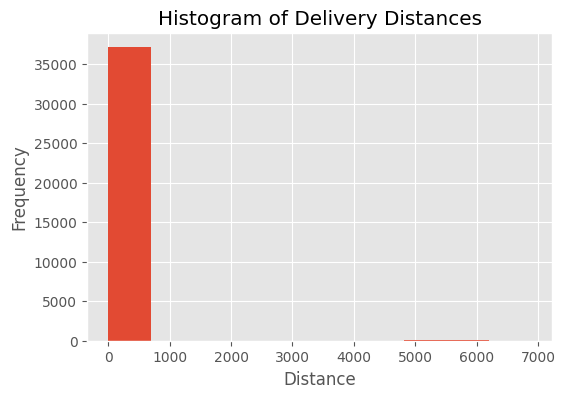

In [10]:
plt.figure(figsize=(6, 4))  # smaller figure size
df['Distance'].hist(bins=10)
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Delivery Distances')
plt.show()

From the distribution, we observe that the majority of delivery distances fall between 0 and just under 1,000, while a smaller group of distances ranges from slightly below 5,000 up to 6,000. To better understand these patterns, we take a closer look at two distinct groups in the data: distances above 1000  and below this value.

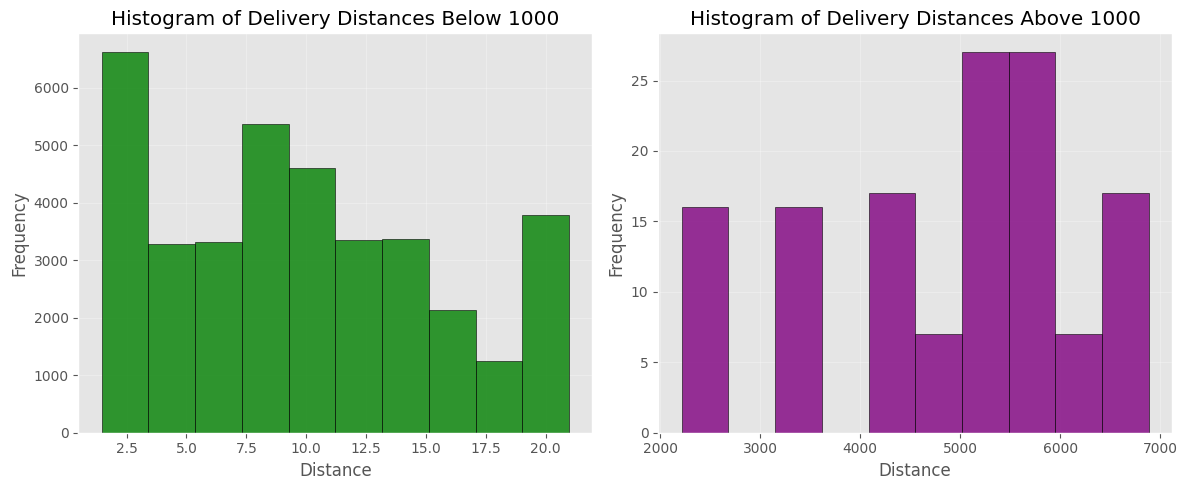

In [11]:
import matplotlib.pyplot as plt

# Filter data into distict groups
distances_above_1000 = df[df['Distance'] >= 1000]
distances_below_1000 = df[df['Distance'] < 1000]

# Create subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Plot distances below 1000 on the left
axes[0].hist(distances_below_1000['Distance'], bins=10, color='green', edgecolor='black', alpha=0.8)
axes[0].set_title('Histogram of Delivery Distances Below 1000')
axes[0].set_xlabel('Distance')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, alpha=0.3)

# Plot distances above 1000 on the right
axes[1].hist(distances_above_1000['Distance'], bins=10, color='purple', edgecolor='black', alpha=0.8)
axes[1].set_title('Histogram of Delivery Distances Above 1000')
axes[1].set_xlabel('Distance')
axes[1].set_ylabel('Frequency')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Based on the distribution plots, the majority of delivery distances fall below 22.5, strongly indicating that the distances are measured in kilometers rather than meters or any other unit. Filtering out values below 1,000 reveals a realistic range from 0 to just under 25 km, which aligns well with typical delivery distances. Although a small number of distances appear between 5,000 and 6,000, they occur very rarely and likely represent anomalies. This analysis confirms that kilometers is the correct unit of measurement for the distance data. Consequently,we decided to remove the few rows with distances under 25 km, assuming these values result from errors in the GPS latitude and longitude measurements.

In [12]:
df = df[df['Distance'] <= 25]
df

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,...,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),Distance
0,0xd224,DEHRES11DEL03,21.0,4.9,0.000000,0.000000,0.060000,0.060000,15-02-2022,21:35:00,...,Sunny,Jam,2.0,Buffet,motorcycle,0.0,No,Urban,17.0,9.435202
1,0x30d6,RANCHIRES18DEL02,23.0,4.8,23.351489,85.324253,23.371489,85.344253,05-04-2022,10:55:00,...,Sunny,Low,2.0,Drinks,electric_scooter,1.0,No,Urban,22.0,3.018907
2,0x8f18,INDORES18DEL02,39.0,4.6,22.753839,75.897429,22.833838,75.977429,31-03-2022,17:15:00,...,Windy,Medium,0.0,Drinks,motorcycle,0.0,No,Metropolitian,32.0,12.098934
3,0xdbd2,KOCRES02DEL03,23.0,4.5,10.028047,76.310019,10.088047,76.370019,15-02-2022,21:50:00,...,Sandstorms,Jam,2.0,Meal,scooter,1.0,No,Metropolitian,22.0,9.362980
4,0x129b,VADRES08DEL01,31.0,4.2,0.000000,0.000000,0.040000,0.040000,15-03-2022,14:15:00,...,Windy,High,0.0,Buffet,motorcycle,2.0,No,Urban,41.0,6.290135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37226,0x799d,INDORES14DEL02,39.0,4.4,22.761593,75.886362,22.891593,76.016362,29-03-2022,21:00:00,...,Fog,Jam,1.0,Snack,scooter,1.0,No,Urban,41.0,19.658728
37227,0xb350,MUMRES20DEL02,20.0,4.9,19.103249,72.846749,19.183249,72.926749,06-04-2022,22:00:00,...,Stormy,Jam,1.0,Snack,scooter,0.0,No,Metropolitian,23.0,12.237379
37228,0x6a92,VADRES01DEL01,31.0,4.9,22.307898,73.167788,22.317898,73.177788,01-04-2022,10:35:00,...,Sunny,Low,2.0,Meal,scooter,1.0,No,Urban,16.0,1.514806
37229,0x2484,VADRES05DEL01,32.0,4.9,22.310526,73.170937,22.350526,73.210937,30-03-2022,12:55:00,...,Sunny,High,1.0,Drinks,motorcycle,1.0,No,Metropolitian,19.0,6.058871


**Adding  day of the week  and hour of the day columns  for the delivery orders and exploring potential correlations with the delivery time spent.**

In [13]:
df['Time_Orderd']

,Time_Orderd
0,21:35:00
1,10:55:00
2,17:15:00
3,21:50:00
4,14:15:00
...,...
37226,21:00:00
37227,22:00:00
37228,10:35:00
37229,12:55:00


In [14]:


# Convert 'Order_Date' to datetime
df['Order_Date'] = pd.to_datetime(df['Order_Date'])

# Extract day name
df['Day_of_Week'] = df['Order_Date'].dt.day_name()

# Make 'Day_of_Week' a categorical type with the order from Monday to Sunday
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['Day_of_Week'] = pd.Categorical(df['Day_of_Week'], categories=days_order, ordered=True)

# Get value counts sorted by day order
df['Day_of_Week'].value_counts().sort_index()




<ipython-input-14-4c7e5134fa61>:2: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Order_Date'] = pd.to_datetime(df['Order_Date'])
<ipython-input-14-4c7e5134fa61>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Order_Date'] = pd.to_datetime(df['Order_Date'])
<ipython-input-14-4c7e5134fa61>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Day_of_Week'] = df['Order_Date'].dt.day_name

,count
Day_of_Week,
Monday,5056
Tuesday,5196
Wednesday,5808
Thursday,5160
Friday,5705
Saturday,5099
Sunday,5073


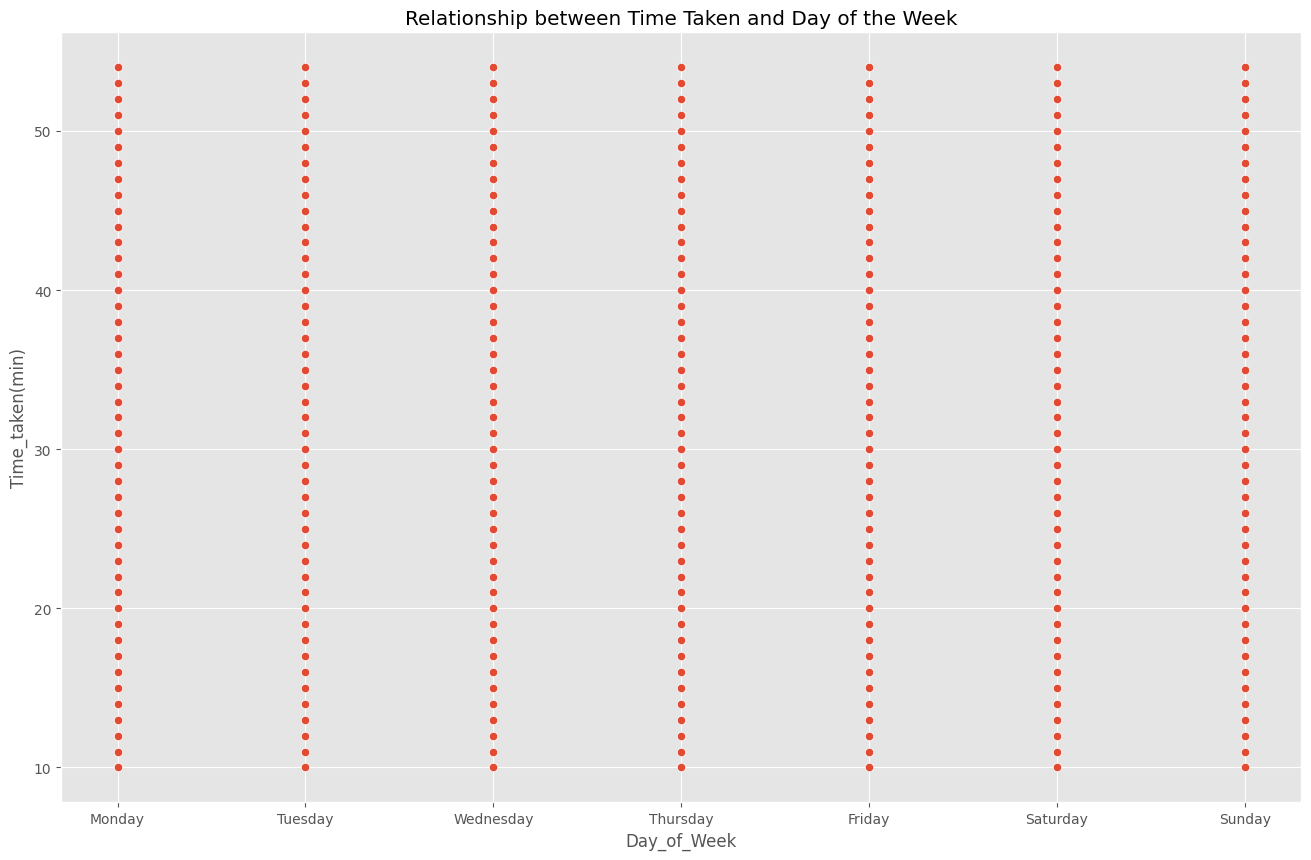

In [15]:
sns.scatterplot(x="Day_of_Week", y="Time_taken(min)", data=df)
plt.title("Relationship between Time Taken and Day of the Week")
plt.show()


From the scatterplot above, it appears that there is no linear relationship between the day of the week and the delivery time. As a result, this column will be encoded using one-hot encoding.

In [16]:

df['Time_Orderd'] = pd.to_datetime(df['Time_Orderd'], format='%H:%M:%S')


df['Ordered_Hour'] = df['Time_Orderd'].dt.hour

df['Ordered_Hour'].value_counts().sort_index()




<ipython-input-16-d1dfa5cb4ff5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Time_Orderd'] = pd.to_datetime(df['Time_Orderd'], format='%H:%M:%S')
<ipython-input-16-d1dfa5cb4ff5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Ordered_Hour'] = df['Time_Orderd'].dt.hour


,count
Ordered_Hour,
0,357
8,1512
9,1615
10,1684
11,1642
12,760
13,649
14,674
15,748


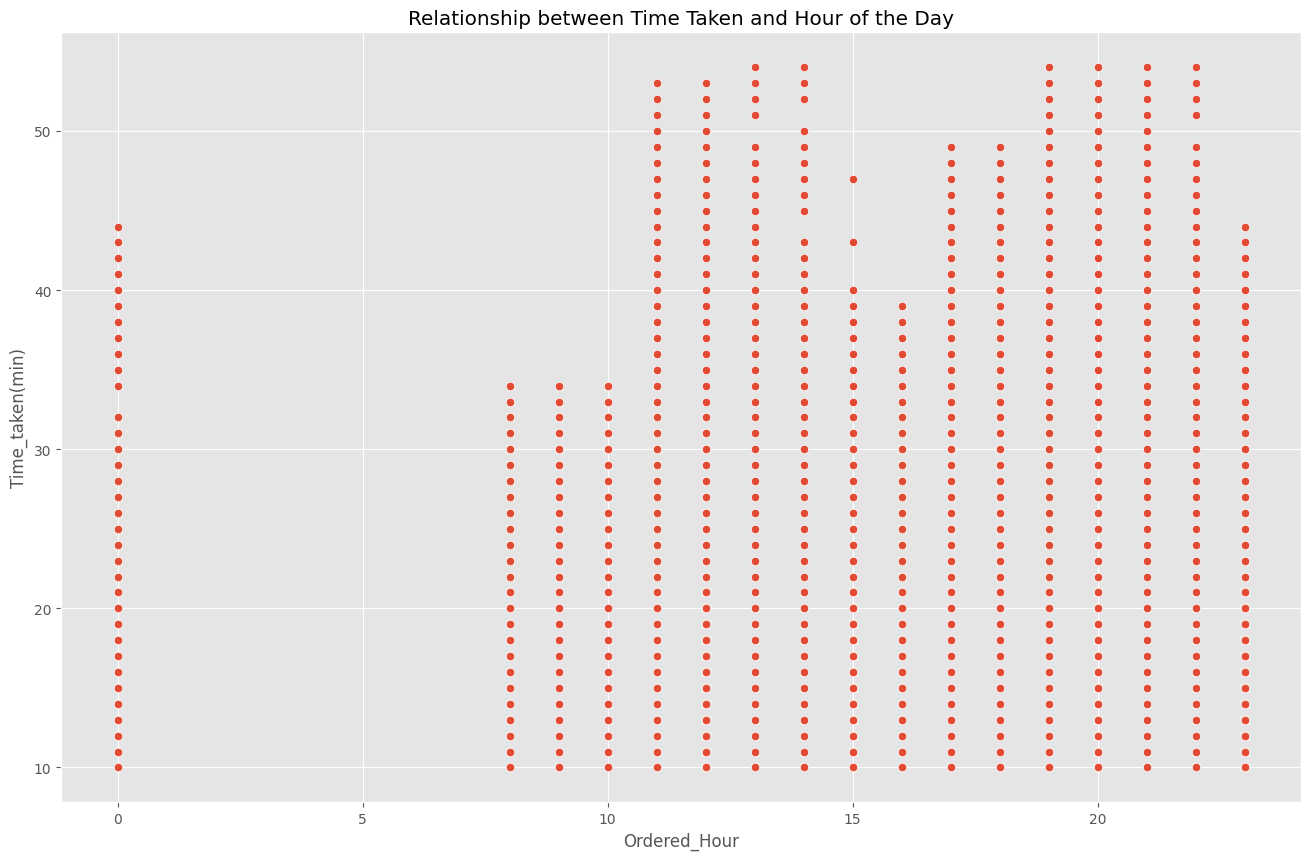

In [17]:

plt.title("Relationship between Time Taken and Hour of the Day")
sns.scatterplot(x="Ordered_Hour", y="Time_taken(min)", data=df)
plt.show()

Based on the scatterplot, it appears to be no linear relationship between the hour a delivery is ordered and the delivery time. Therefore, this column will be encoded using one-hot encoding.

**Data Visualization of numerical variables distribution**

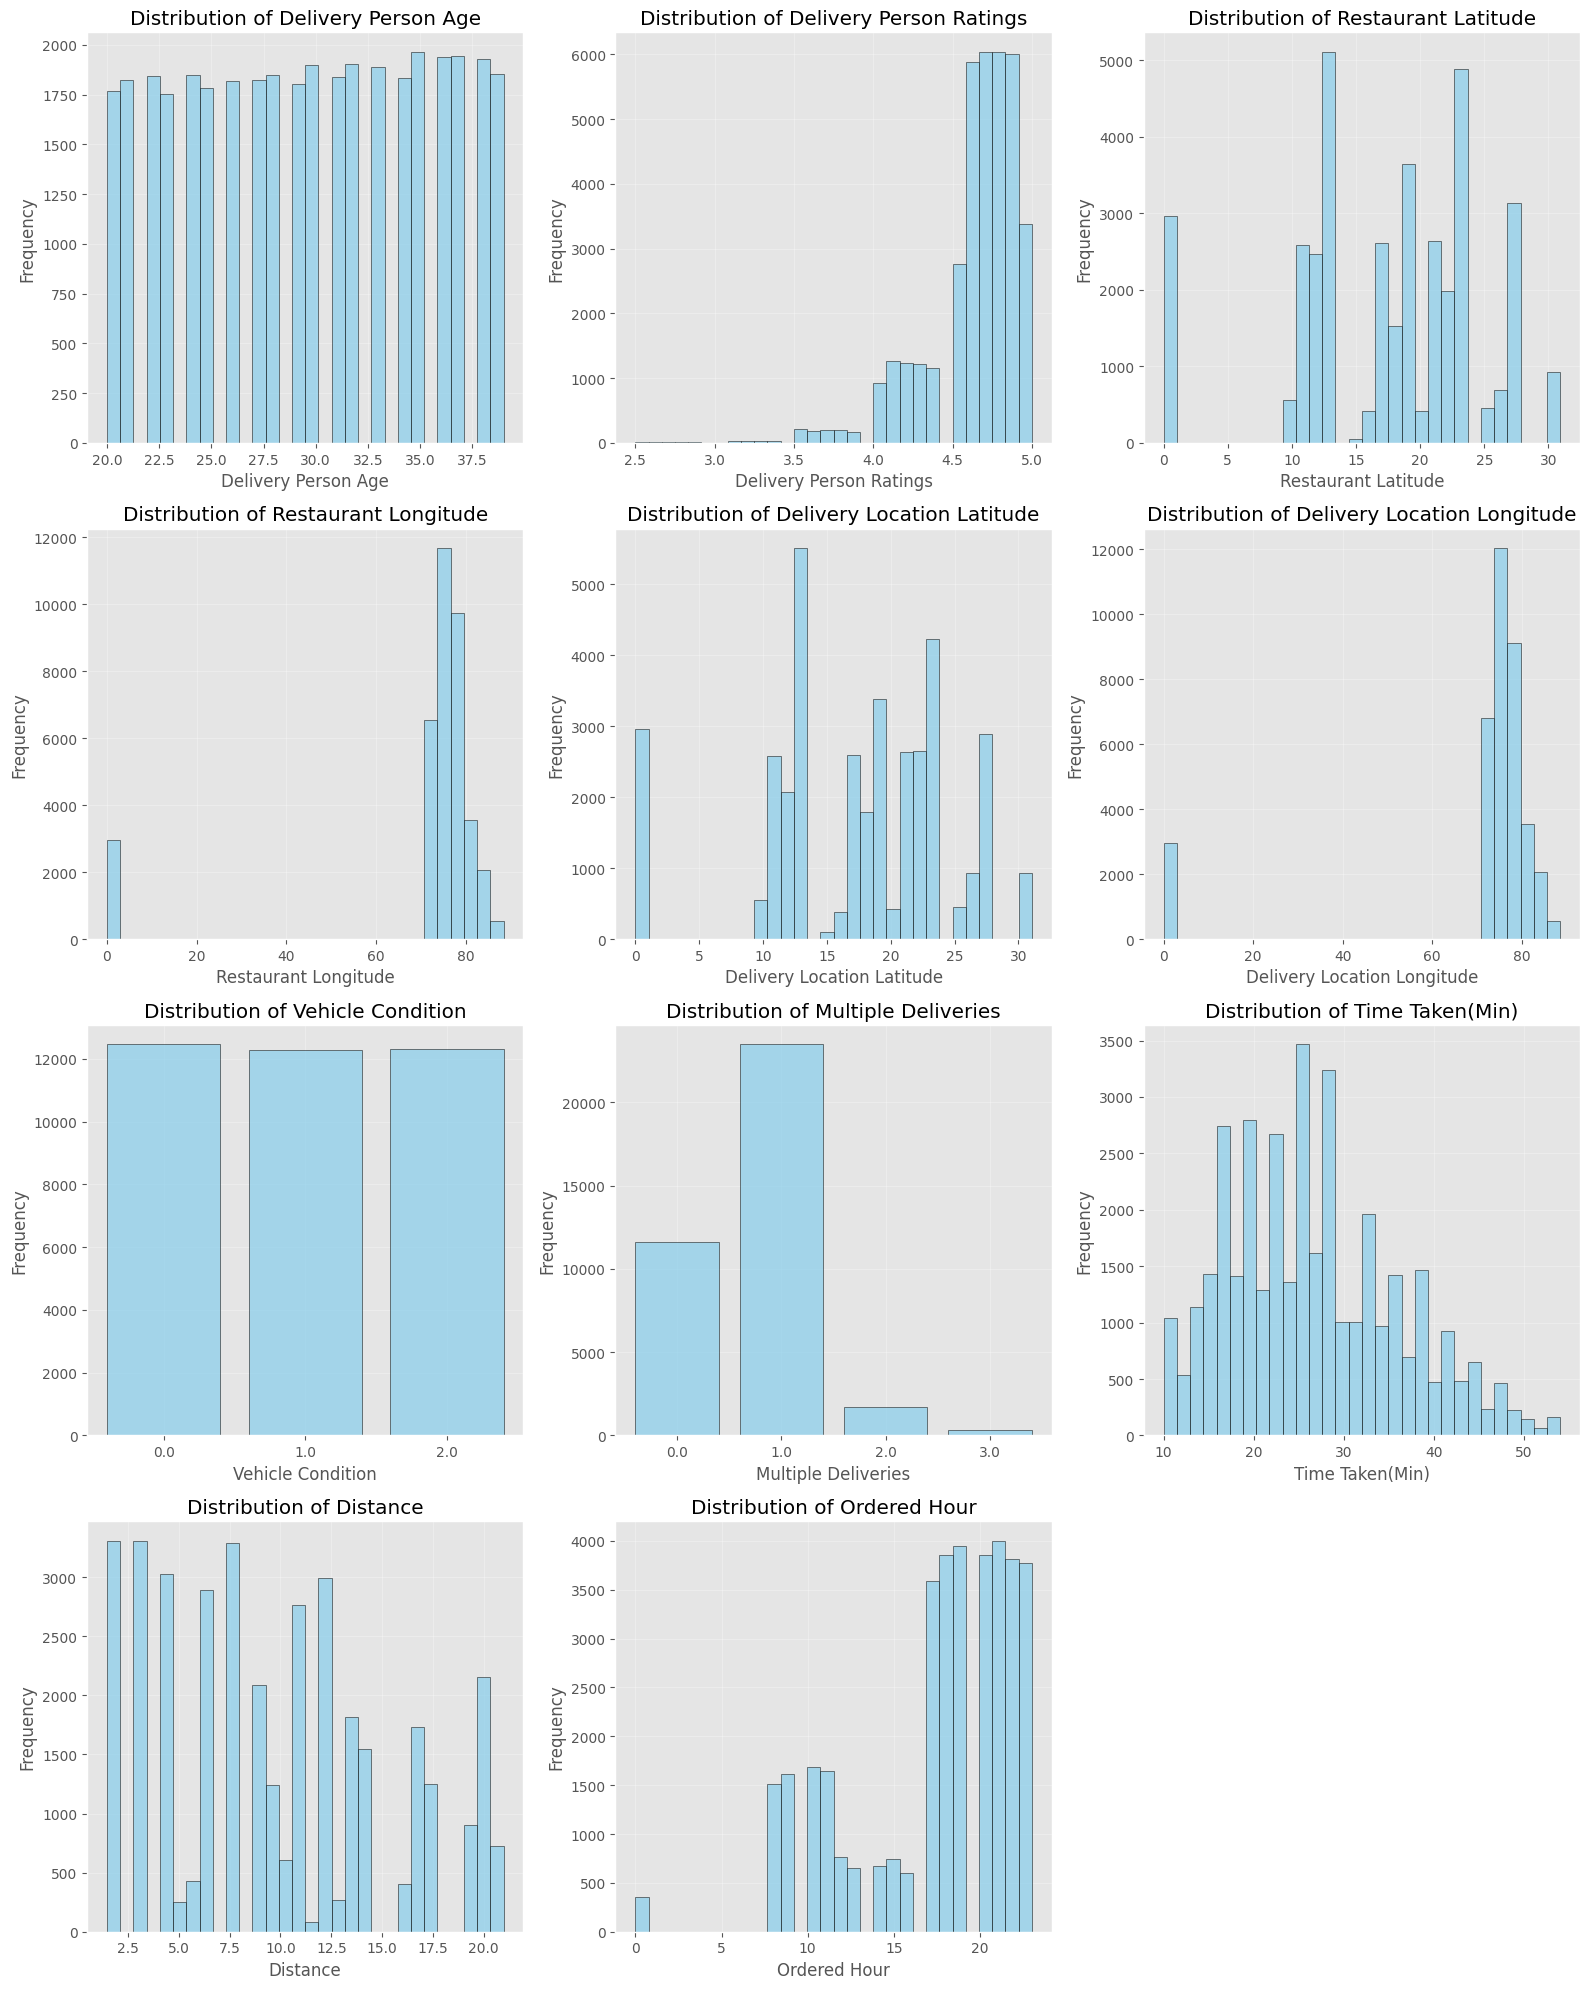

In [ ]:
#Implementation of a function that given a dataframe plot the distribution of numerical columns of it.


def plot_numerical_distributions(df):
    numerical_columns = list(df.select_dtypes(include=np.number).columns)
    n_cols = 3
    n_rows = math.ceil(len(numerical_columns) / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5 * n_rows))
    axes = axes.flatten()

    for i, column in enumerate(numerical_columns):
        if column in ['multiple_deliveries', 'Vehicle_condition']:
            # Use bar chart for discrete features
            value_counts = df[column].value_counts().sort_index()
            axes[i].bar(value_counts.index.astype(str), value_counts.values, color='skyblue', alpha=0.7, edgecolor='black')
        else:
            # Use histogram for continuous features
            axes[i].hist(df[column].dropna(), bins=30, color='skyblue', alpha=0.7, edgecolor='black')

        axes[i].set_title(f'Distribution of {column.replace("_", " ").title()}')
        axes[i].set_xlabel(column.replace("_", " ").title())
        axes[i].set_ylabel('Frequency')
        axes[i].grid(True, alpha=0.3)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()
plot_numerical_distributions(df)


**Data Visualization of categorical variables distribution**

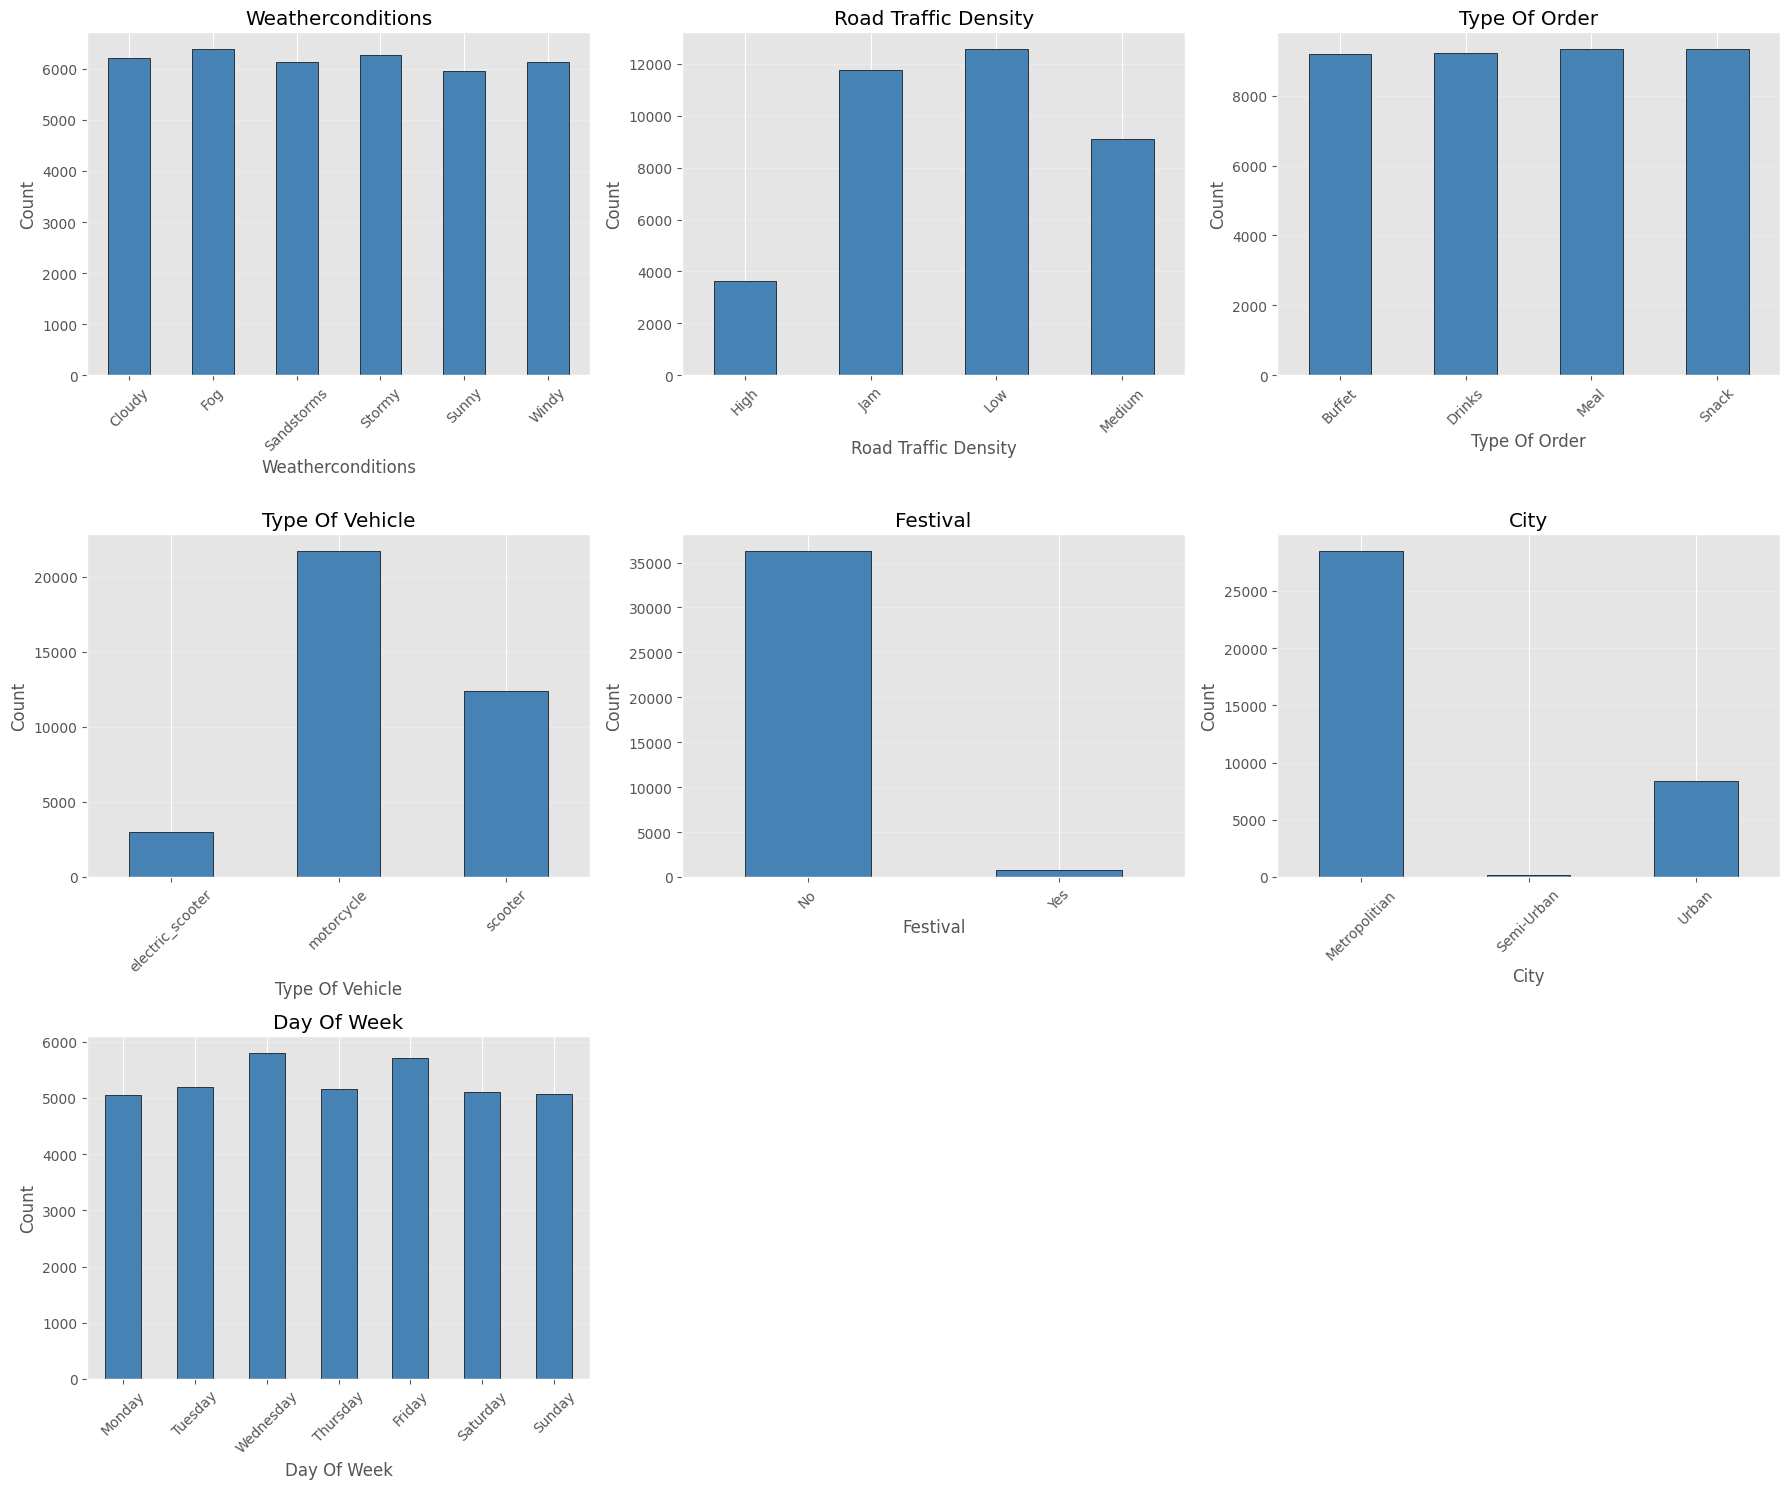

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import math

def plot_categorical_distributions(df):
    not_selected_columns = ['ID', 'Delivery_person_ID', 'Time_Order_picked']
    categorical_columns = [
        col for col in df.select_dtypes(include=['object', 'category']).columns
        if col not in not_selected_columns
    ]

    n_cols = 3
    n_rows = math.ceil(len(categorical_columns) / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
    axes = axes.flatten()

    for i, column in enumerate(categorical_columns):
        df[column].value_counts().sort_index().plot(
            kind='bar',
            ax=axes[i],
            color='steelblue',
            edgecolor='black'
        )
        axes[i].set_title(f'{column.replace("_", " ").title()}')
        axes[i].set_xlabel(column.replace("_", " ").title())
        axes[i].set_ylabel('Count')
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].grid(axis='y', alpha=0.3)

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()
plot_categorical_distributions(df)


**Identifying counts of possible values for each different kind of weather condition and encoding via one-hot-encoding**

In [ ]:
df['Weatherconditions'].sort_values().value_counts()

,count
Weatherconditions,
Fog,6398
Stormy,6267
Cloudy,6223
Windy,6128
Sandstorms,6127
Sunny,5954


We use one-hot encoding forthe following  weather conditions because they have no always a meaningful strict order among the possible weather conditions. In such case, label encoding could mislead the model into thinking there's a hierarchy, and to prevent this  one-hot econding  allows us to treat  each condition as a separate category.

In [ ]:
weather_conditions=pd.get_dummies(df['Weatherconditions']).astype(int)
weather_conditions

,Cloudy,Fog,Sandstorms,Stormy,Sunny,Windy
0,0,0,0,0,1,0
1,0,0,0,0,1,0
2,0,0,0,0,0,1
3,0,0,1,0,0,0
4,0,0,0,0,0,1
...,...,...,...,...,...,...
37226,0,1,0,0,0,0
37227,0,0,0,1,0,0
37228,0,0,0,0,1,0
37229,0,0,0,0,1,0


**Encoding road traffic density variable using label encoding**

We proceed to encode the road traffic density variable, which is an ordinal categorical variable with levels: Low, Medium, High, and Jam. These levels represent a natural progression in the severity of traffic conditions and are therefore suitable for label encoding using numerical values.


In [ ]:
#Creating a dictionary for encoding traffic condition

traffic_encoding = {
    "Low":0,
    "Medium":1,
    "High":2,
    "Jam":3}


df['Road_traffic_density']=df['Road_traffic_density'].map(traffic_encoding)
df['Road_traffic_density'].sort_values().value_counts()


<ipython-input-323-94147046fc31>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Road_traffic_density']=df['Road_traffic_density'].map(traffic_encoding)


,count
Road_traffic_density,
0,12592
3,11771
1,9093
2,3641


**Encoding festival variable**


In [ ]:
df['Festival']=df['Festival'].map({'Yes':0,'No':1})
df['Festival'].sort_values().value_counts()


<ipython-input-324-54c69e9e0e96>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Festival']=df['Festival'].map({'Yes':0,'No':1})


,count
Festival,
1,36336
0,761


In [ ]:
X_festival=np.array(df[['Festival']])
X_festival

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

**Identifying number  of columns in the current dataframe**

In [ ]:
print('The number of columsn is:',len(df.columns))
print('The columns are ')
for column in df.columns:
  print(column)

The number of columsn is: 23
The columns are 
ID
Delivery_person_ID
Delivery_person_Age
Delivery_person_Ratings
Restaurant_latitude
Restaurant_longitude
Delivery_location_latitude
Delivery_location_longitude
Order_Date
Time_Orderd
Time_Order_picked
Weatherconditions
Road_traffic_density
Vehicle_condition
Type_of_order
Type_of_vehicle
multiple_deliveries
Festival
City
Time_taken(min)
Distance
Day_of_Week
Ordered_Hour


**Saving the dataset cleaned and preprocessed into a new excel file**


In [ ]:
df.to_csv('food_delivery_data_preprocessed.csv')

#Part 3:  Bayesian Linear Regression




##Part 3.1: Features selection

From the exploratory data analysis, the dataset was expanded to 24 columns by including features such as day of the week, order hour, and delivery distance. Our objective is to predict delivery time by selecting features based on logical reasoning.

To predict delivery time accurately, we chose features that reflect the main factors influencing delivery conditions. For example, distance directly relates to how long a delivery should take. Weather conditions are represented through one-hot encoded indicators such as rain, sun, or fog, which affect traffic flow. We also include the day of the week and hour of the day, both one-hot encoded to capture time-based variations without assuming any inherent order. Finally, road traffic density is included to provide essential context about congestion.









**Preparing input features and target for our forecasting task**

In [ ]:
X_traffic = np.array(df['Road_traffic_density']).reshape(-1,1)
X_distance = np.array(df['Distance']).reshape(-1,1)
X_weather= pd.get_dummies(df['Weatherconditions']).astype(int).values
X_time = np.concatenate([pd.get_dummies(df[x]).astype(int) for x in ["Day_of_Week", "Ordered_Hour"]], axis=1)
X=np.concatenate([X_distance,X_traffic,X_weather,X_time],axis=1)
y=np.array(df['Time_taken(min)'])
print('Features shape',X.shape)
print('Target shape',y.shape)


Features shape (37097, 32)
Target shape (37097,)


**Standardization of  both input features  and target variable**

In [ ]:
#standardizing X
X_mean = X.mean()
X_std = X.std()
X= (X- X_mean)/X_std
X

array([[ 4.50722615,  1.28167983, -0.22202428, ...,  0.27921042,
        -0.22202428, -0.22202428],
       [ 1.29115667, -0.22202428, -0.22202428, ..., -0.22202428,
        -0.22202428, -0.22202428],
       [ 5.84238149,  0.27921042, -0.22202428, ..., -0.22202428,
        -0.22202428, -0.22202428],
       ...,
       [ 0.537249  , -0.22202428, -0.22202428, ..., -0.22202428,
        -0.22202428, -0.22202428],
       [ 2.81489188,  0.78044513, -0.22202428, ..., -0.22202428,
        -0.22202428, -0.22202428],
       [ 4.2590376 ,  0.27921042, -0.22202428, ..., -0.22202428,
        -0.22202428, -0.22202428]])

In [ ]:
#standardizing y
y_mean = y.mean()
y_std = y.std()
y = (y- y_mean)/y_std
y

array([-1.02263621, -0.48720138,  0.58366827, ..., -1.12972318,
       -0.80846228, -1.66515801])

##Part 3.2: Baseline Model: Ridge Regression

To provide a baseline for evaluate our bayesian model , we trained a Ridge regression model. In particular this will be  compared  it later with  the Bayesian linear regression.


**Splitting the dataset into training and test dataset**

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)
X_train
y_train
X_test
y_test
print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))




num train: 24854
num test: 12243


**Fitting a Ridge Regression model to the training dataset**

In [ ]:
from sklearn.linear_model import Ridge
lr = Ridge()
lr.fit(X_train, y_train)

Ridge()

**Implementation of a funciton which provides an overview of  popular metrics for evaluating the accuracy of the predictions of a regression model**

In [ ]:
def compute_error(true, predicted):
    corr = np.corrcoef(predicted, true)[0,1]
    mae = np.mean(np.abs(predicted - true))
    rae = np.sum(np.abs(predicted - true)) / np.sum(np.abs(true - np.mean(true)))
    rmse = np.sqrt(np.mean((predicted - true)**2))
    r2 = max(0, 1 - np.sum((true-predicted)**2) / np.sum((true - np.mean(true))**2))
    return corr, mae, rae, rmse, r2

**Predicting and evaluating Ridge Regression**

In [ ]:

y_hat = lr.predict(X_test)
# convert back to the original scale
prediction = y_hat * y_std + y_mean
y_true = y_test * y_std + y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, prediction)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.546
MAE: 6.307
RMSE: 7.830
R2: 0.298


**Visualization for comparing the predictions of Ridge Regression with the actual values for the delivery time from the dataset**

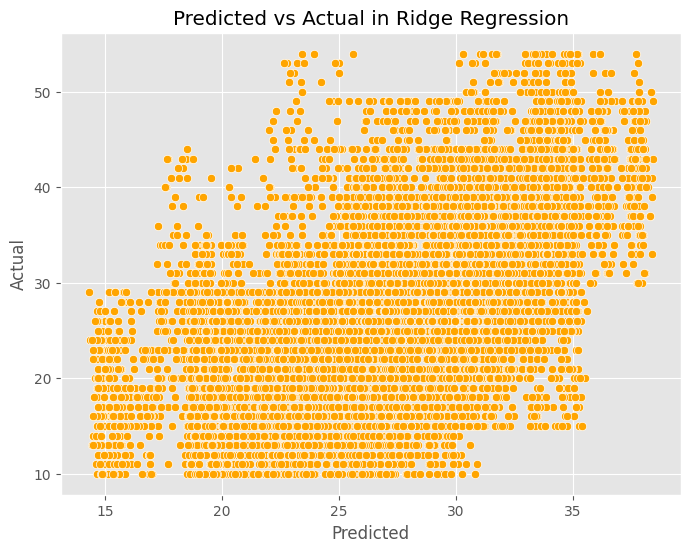

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.scatterplot(x=prediction, y=y_true, color='orange')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Predicted vs Actual in Ridge Regression')
plt.show()


##Part 3.3: Bayesian Linear Regression in Pyro with Inference via MCMC (NUTS) and SVI

**Implementing a Bayesian linear regression model in Pyro**




In [ ]:
def model(X, obs=None):
    alpha = pyro.sample("alpha", dist.Normal(0., 1.))                   # Prior for the bias/intercept
    beta  = pyro.sample("beta", dist.Normal(torch.zeros(X.shape[1]),
                                            torch.ones(X.shape[1])).to_event())    # Priors for the regression coeffcients
    sigma = pyro.sample("sigma", dist.HalfCauchy(5.))                   # Prior for the variance

    with pyro.plate("data"):
        y = pyro.sample("y", dist.Normal(alpha + X.matmul(beta), sigma), obs=obs)

    return y

**Doing inference on the model using MCMC (NUTS) applied on a training set of 1000 datapoints**



In [ ]:
# Prepare data for Pyro model
X_train_small = torch.tensor(X_train[:1000,:]).float()
y_train_small = torch.tensor(y_train[:1000]).float()

To perform inference, we use Markov Chain Monte Carlo (MCMC), a stochastic algorithm designed to sample from the posterior distribution. By drawing these samples, we can approximate the true posterior and compute expectations over model parameters. In this particular, inference on the prior parameters α (alpha) and β (beta) is conducted using the No-U-Turn Sampler (NUTS), an advanced variant of MCMC. NUTS builds on Hamiltonian Monte Carlo (HMC) by automatically adapting the trajectory length during sampling, which helps avoid inefficient random walks and improves convergence efficiency. The model is trained on the training dataset, and after convergence, samples of the intercept and β parameters are drawn from the posterior. These posterior samples are then used to make predictions on the test dataset and assess the model’s accuracy.

In [ ]:
# Run inference in Pyro
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200, num_chains=1)
mcmc.run(X_train_small, y_train_small)

# Show summary of inference results
mcmc.summary()

Sample: 100%|██████████| 1200/1200 [12:07,  1.65it/s, step size=3.69e-02, acc. prob=0.936]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha     -0.49      0.69     -0.46     -1.53      0.61    221.44      1.00
   beta[0]      0.14      0.01      0.14      0.12      0.16    987.57      1.00
   beta[1]      0.49      0.14      0.49      0.26      0.73    273.96      1.00
   beta[2]      0.52      0.38      0.53     -0.12      1.13    429.97      1.00
   beta[3]      0.63      0.39      0.62     -0.06      1.21    449.79      1.00
   beta[4]     -0.03      0.38     -0.03     -0.62      0.61    463.21      1.00
   beta[5]     -0.04      0.39     -0.05     -0.76      0.52    427.36      1.00
   beta[6]     -0.72      0.39     -0.73     -1.38     -0.11    453.21      1.00
   beta[7]      0.09      0.38      0.09     -0.47      0.79    444.15      1.00
   beta[8]     -0.13      0.41     -0.13     -0.76      0.58    179.71      1.01
   beta[9]      0.29      0.40      0.30     -0.31      0.96    159.58      1.01
  beta[10]      0.10      0

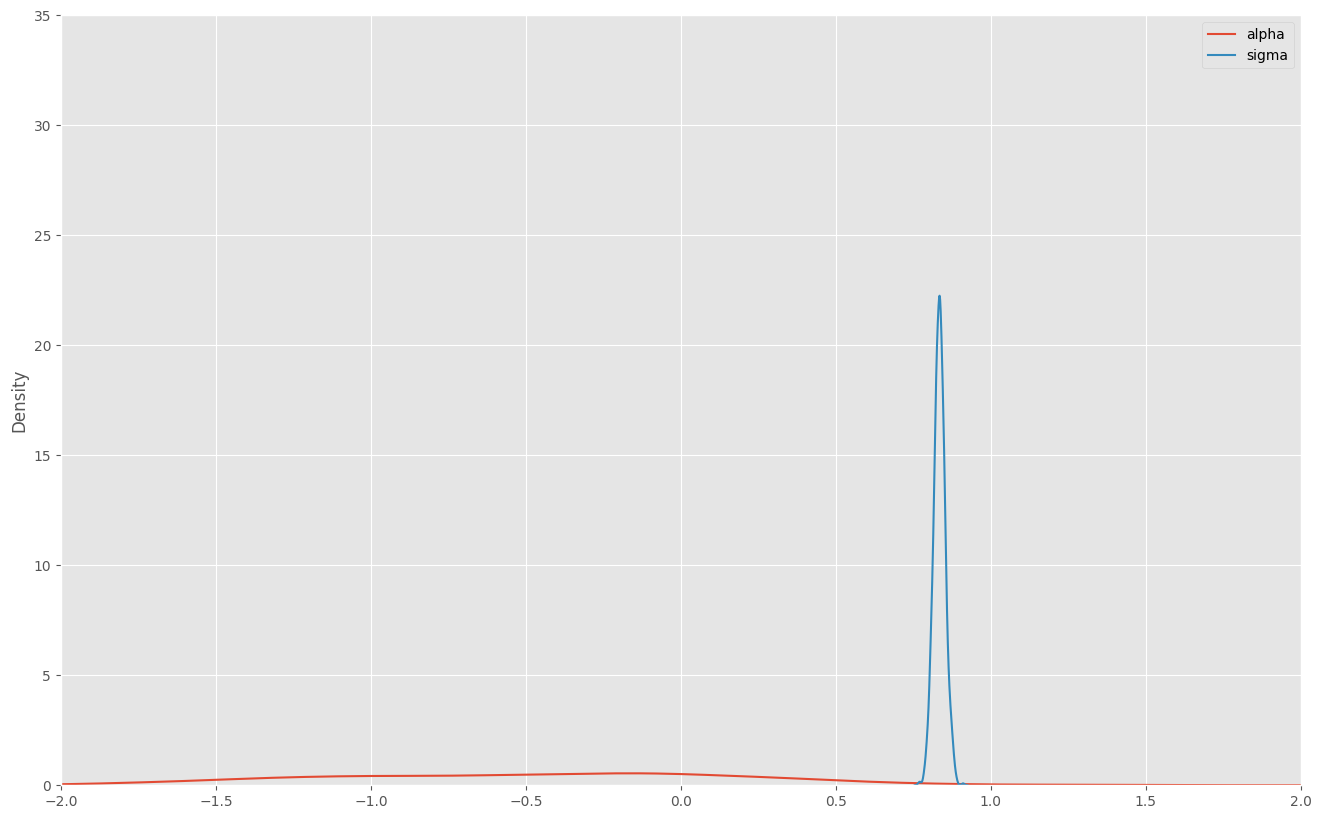

In [ ]:
# Extract samples from posterior
posterior_samples = mcmc.get_samples()

sns.kdeplot(posterior_samples["alpha"])
sns.kdeplot(posterior_samples["sigma"])

# Alternative
#sns.histplot(data=posterior_samples["alpha"], kde=True, stat='density', color=next(palette), element="step")
#sns.histplot(data=posterior_samples["sigma"], kde=True, stat='density', color=next(palette), element="step")

plt.legend(["alpha", "sigma"])
plt.axis([-2,2,0,35])
plt.show()

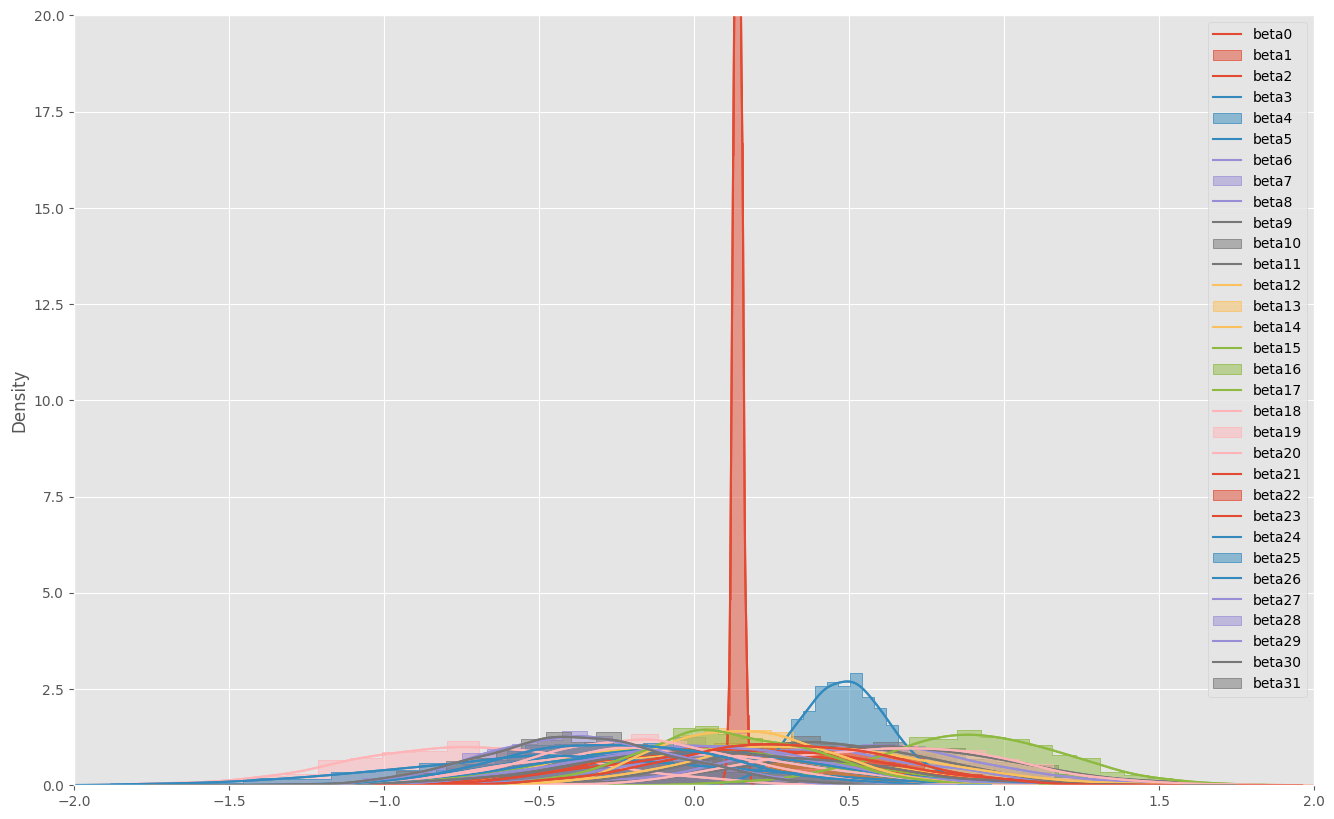

In [ ]:
for i in range(X.shape[1]):
    sns.kdeplot(posterior_samples["beta"][:,i])
    # Alternative
    sns.histplot(data=posterior_samples["beta"][:,i], kde=True, stat='density', color=next(palette), element="step")
plt.legend(["beta%d" % i for i in range(X.shape[1])])
plt.axis([-2,2,0,20])
plt.show()

Extracting the posterior samples from Pyro and make predictions for the test set

In [ ]:
# Extract samples from posterior
posterior_samples = mcmc.get_samples()

# Compute predictions
y_hat = np.mean(posterior_samples["alpha"].numpy().T + np.dot(X_test, posterior_samples["beta"].numpy().T), axis=1)

Displaying accuracy metrics for bayesian regression deploying MCMC(NUTS) inference algorithm

In [ ]:
# Convert back to the original scale
preds = y_hat * y_std + y_mean
y_true = y_test * y_std + y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.529
MAE: 6.391
RMSE: 7.952
R2: 0.276


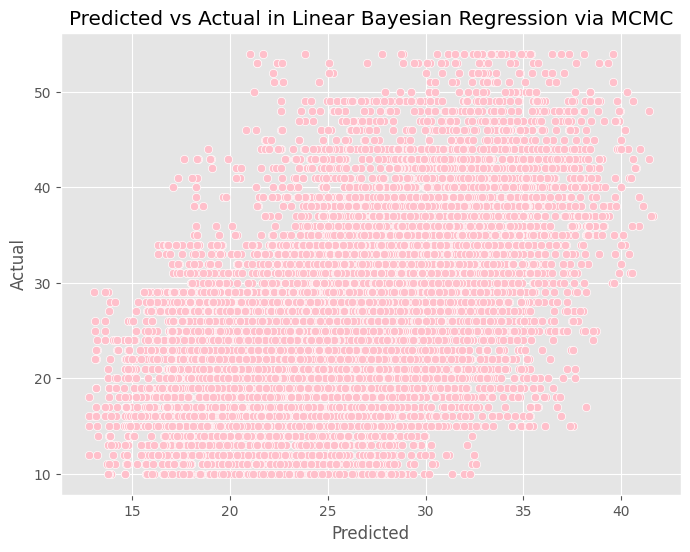

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.scatterplot(x=preds, y=y_true, color='pink')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Predicted vs Actual in Linear Bayesian Regression via MCMC')
plt.show()


**Bayesian Linear Regression on the full training dataset via Stochastic Variational Inference (SVI)**



Our Bayesian linear regression model is trained using Stochastic Variational Inference (SVI).
This method aims to approximate the true posterior distribution *p(z|x)* by introducing
a simpler variational distribution *q(z)*. The goal is to make  *q(z)* lie as close as possible to the true posterior *p(z|x)*.







 This is achieved by minimizing the Kullback-Leibler (KL) divergence between the variational
distribution and the true posterior:

$$
\text{KL}(q(z) \| p(z \mid x)) = -\left( \mathbb{E}_q[\log p(z, x)] - \mathbb{E}_q[\log q(z)] \right) + \log p(x)
$$

This equation consists of two main components:

$$
\underbrace{\left( \mathbb{E}_q[\log p(z, x)] - \mathbb{E}_q[\log q(z)] \right)}_{\text{ELBO}}
+ \underbrace{\log p(x)}_{\text{log evidence}}
$$

In particular the ELBO (Evidence Lower Bound) quantifies how close the variational distribution is to the true posterior, where the log evidence *log p(x)* is constant with respect to *q(z)* and represents the marginal likelihood.

Since the  *log p(x)* is independent of *q(z)*, minimizing the KL divergence is equivalent to maximizing the ELBO.
As the ELBO increases, the variational distribution *q(z)* improves and becomes a more accurate approximation  for the true posterior.

In our implementation, we monitor the ELBO at each optimization step (even though in reality we are looking for loss corresponding to the negative ELBO, which means the shorter is the loss, the greater is the ELBO). Once the  convergence is achieved, the resulting approximate posterior is used to generate predictions and the model accuracy is then assessed by comparing these predictions with the actual values in the test dataset.

In order to carry out inference in our model by applying  SVI  we firstly prepare the data by converting it into torch tensors.

In [ ]:
# Prepare data for Pyro model
X_train_torch = torch.tensor(X_train).float()
y_train_torch = torch.tensor(y_train).float()

In Pyro, the approximation to the posterior distribution is defined using a special function called a guide, which works alongside the model. There are built-in tools that can automatically create this guide for you, simplifying the process of setting up the inference. For example, classes like AutoMultivariateNormal help generate the guide without needing to write it manually.

In [ ]:
# Define guide function
guide = AutoMultivariateNormal(model)

# Reset parameter values
pyro.clear_param_store()

The stochastic variational inference reformulates the problem of approximate Bayesian inference as an optimization task. To solve this, we need to define an optimizer, a loss function, and the components of the variational model. In our case, we use the ClippedAdam optimizer, which adjusts the learning rate adaptively to improve stability. The loss function we rely on is `Trace_ELBO`, which is the default and most commonly used in Pyro. According to the Pyro documentation with regards to the internal implementation of the `Trace_ELBO` class [[1]](https://docs.pyro.ai/en/dev/_modules/pyro/infer/trace_elbo.html) , this loss is actually the negative Evidence Lower Bound (ELBO), meaning that minimizing the loss is equivalent to maximizing the ELBO. If training is proceeding correctly, we should observe the loss values decreasing over time. After setting up the model, guide, optimizer, and loss, the `SVI` object is initialized, and optimization is carried out by calling the `svi.step(...)` function repeatedly to update the variational parameters.





In [ ]:


# Define the number of optimization steps
n_steps = 4000

# Setup the optimizer
adam_params = {"lr": 0.001} # learning rate (lr) of optimizer
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

In [ ]:
# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train_torch, y_train_torch)
    if step % 100 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 58248.0
[100] ELBO: 50112.0
[200] ELBO: 46447.7
[300] ELBO: 51214.4
[400] ELBO: 44539.7
[500] ELBO: 44180.2
[600] ELBO: 42665.9
[700] ELBO: 42265.8
[800] ELBO: 36033.2
[900] ELBO: 36846.4
[1000] ELBO: 33860.0
[1100] ELBO: 32068.6
[1200] ELBO: 31941.7
[1300] ELBO: 31317.8
[1400] ELBO: 32755.4
[1500] ELBO: 31983.4
[1600] ELBO: 31344.2
[1700] ELBO: 31370.4
[1800] ELBO: 31730.1
[1900] ELBO: 31488.5
[2000] ELBO: 31221.2
[2100] ELBO: 31215.3
[2200] ELBO: 31133.0
[2300] ELBO: 31014.2
[2400] ELBO: 31068.9
[2500] ELBO: 30958.8
[2600] ELBO: 30934.4
[2700] ELBO: 31022.0
[2800] ELBO: 30964.6
[2900] ELBO: 30954.6
[3000] ELBO: 30935.8
[3100] ELBO: 30907.0
[3200] ELBO: 30882.2
[3300] ELBO: 30879.9
[3400] ELBO: 30941.9
[3500] ELBO: 30897.7
[3600] ELBO: 30884.0
[3700] ELBO: 30865.8
[3800] ELBO: 30864.0
[3900] ELBO: 30854.5


In [ ]:
from pyro.infer import Predictive

predictive = Predictive(model, guide=guide, num_samples=1000,
                        return_sites=("alpha", "beta", "sigma"))
samples = predictive(X_train_torch, y_train_torch)

In [ ]:
alpha_samples = samples["alpha"].detach().numpy()
beta_samples = samples["beta"].detach().numpy()
y_hat = np.mean(alpha_samples.T + np.dot(X_test, beta_samples[:,0].T), axis=1)

# convert back to the original scale
preds = y_hat * y_std + y_mean
y_true = y_test * y_std + y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))


CorrCoef: 0.544
MAE: 6.316
RMSE: 7.842
R2: 0.296


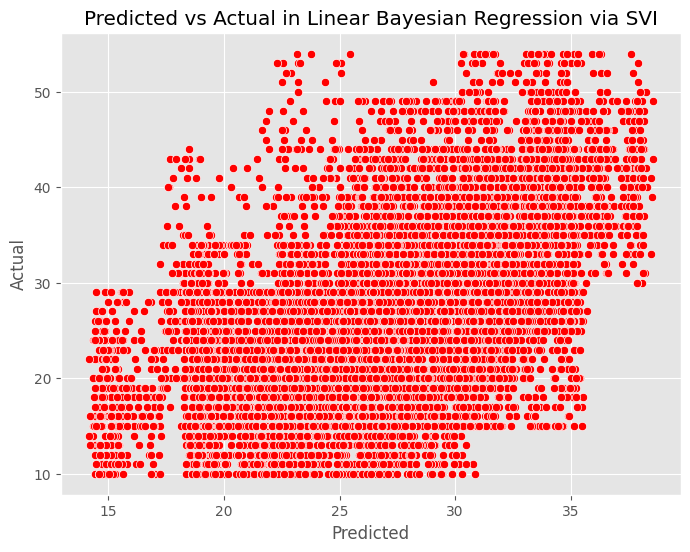

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.scatterplot(x=preds, y=y_true, color='red')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Predicted vs Actual in Linear Bayesian Regression via SVI')
plt.show()


**Overview of the performance for Regression Models:  Ridge Regression, Bayesian Linear Regression via MCMC(NUTS) and Bayesian Linear Regression via SVI**


| Metric        | Ridge Regression | Bayesian Linear Regression (MCMC - NUTS) | Bayesian Linear Regression (SVI) |
|---------------|------------------|------------------------------------------|----------------------------------|
| CorrCoef      | 0.546            | 0.529                                    | 0.544                            |
| MAE           | 6.307            | 6.391                                    | 6.316                            |
| RMSE          | 7.830            | 7.952                                    | 7.842                            |
| R² Score      | 0.298            | 0.276                                    | 0.296                            |



#Part 4: Probabilistic graphical model




In the next section, the bayesian linear regression will be extended to create a hierarchical model.

The first addition will be that for each vehicle type seperate betas are sampled from the same underlying distribution. The intuitive assumption here is: e.g., a traffic jam impacts a scooter differently than a motorcycle because the travel speed might be reduced more for a motorcycle.

The second addition is that the distance-variable calculated above is the closest possible distance between pick-up and delivery location. In practice, the driver will follow streets, thus the actual distance will be larger. It is assumed that the added distance might be different depending on the city type (i.e., rural vs urban).

# Part 5: Hierarchical Modelling

##Part 5.1: The Model

**Implementing a Hierarchical model in Pyro**

In [ ]:
class HierarchicalModel(PyroModule):
    def __init__(self, num_vehicle_types, num_city_types, x_rest_dim):
        super().__init__()
        self.K = num_vehicle_types
        self.C = num_city_types
        self.D = x_rest_dim

    def model(self, x, vehicle_type, city_type, y_obs=None, ):
        N = x.shape[0]

        # Priors for global beta distribution
        mu_beta = pyro.sample("mu_beta", dist.Normal(0., 1.).expand([self.D]).to_event(1))
        sigma_beta = pyro.sample("sigma_beta", dist.HalfCauchy(1.).expand([self.D]).to_event(1))

        with pyro.plate("vehicle_types", self.K):
            beta_k = pyro.sample("beta_k", dist.Normal(mu_beta, sigma_beta).to_event(1))  # [K, D]

        with pyro.plate("city_types", self.C):
            sigma_c = pyro.sample("sigma_c", dist.HalfCauchy(1.))
            eps_c = pyro.sample("eps_c", dist.HalfCauchy(1.))

        #eps_d = pyro.sample("eps_d", dist.HalfCauchy(1.0))
        eps_y = pyro.sample("eps_y", dist.HalfCauchy(1.0))

        with pyro.plate("data", N):
            beta_i = beta_k[vehicle_type]         # [N, D]
            sigma_i = sigma_c[city_type]          # [N]
            eps_i = eps_c[city_type]              # [N]

            mu_d = x[:, 0] + sigma_i              # x[:, 0]: distance
            #d = pyro.sample("d", dist.Normal(mu_d, eps_i))  # latent variable
            d = pyro.sample(f"d_{N}", dist.Normal(mu_d, eps_i))

            x_all = torch.cat([d.unsqueeze(1), x[:, 1:]], dim=1)  # [N, D]

            lin_pred = torch.sum(beta_i * x_all, dim=-1)
            y_fin = pyro.sample("y", dist.Normal(lin_pred, eps_y), obs=y_obs)
        return y_fin

##Part 5.2: Data preprocessing Hierarchical

In [ ]:
df2=pd.read_csv('food_delivery_data_preprocessed.csv')
df2.head()
#Removing column representing the index of the row
df2.drop(['Unnamed: 0'], inplace=True, axis=1)
df2

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,...,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),Distance,Day_of_Week,Ordered_Hour
0,0xd224,DEHRES11DEL03,21.0,4.9,0.000000,0.000000,0.060000,0.060000,2022-02-15,1900-01-01 21:35:00,...,2.0,Buffet,motorcycle,0.0,1,Urban,17.0,9.435202,Tuesday,21
1,0x30d6,RANCHIRES18DEL02,23.0,4.8,23.351489,85.324253,23.371489,85.344253,2022-04-05,1900-01-01 10:55:00,...,2.0,Drinks,electric_scooter,1.0,1,Urban,22.0,3.018907,Tuesday,10
2,0x8f18,INDORES18DEL02,39.0,4.6,22.753839,75.897429,22.833838,75.977429,2022-03-31,1900-01-01 17:15:00,...,0.0,Drinks,motorcycle,0.0,1,Metropolitian,32.0,12.098934,Thursday,17
3,0xdbd2,KOCRES02DEL03,23.0,4.5,10.028047,76.310019,10.088047,76.370019,2022-02-15,1900-01-01 21:50:00,...,2.0,Meal,scooter,1.0,1,Metropolitian,22.0,9.362980,Tuesday,21
4,0x129b,VADRES08DEL01,31.0,4.2,0.000000,0.000000,0.040000,0.040000,2022-03-15,1900-01-01 14:15:00,...,0.0,Buffet,motorcycle,2.0,1,Urban,41.0,6.290135,Tuesday,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37092,0x799d,INDORES14DEL02,39.0,4.4,22.761593,75.886362,22.891593,76.016362,2022-03-29,1900-01-01 21:00:00,...,1.0,Snack,scooter,1.0,1,Urban,41.0,19.658728,Tuesday,21
37093,0xb350,MUMRES20DEL02,20.0,4.9,19.103249,72.846749,19.183249,72.926749,2022-04-06,1900-01-01 22:00:00,...,1.0,Snack,scooter,0.0,1,Metropolitian,23.0,12.237379,Wednesday,22
37094,0x6a92,VADRES01DEL01,31.0,4.9,22.307898,73.167788,22.317898,73.177788,2022-04-01,1900-01-01 10:35:00,...,2.0,Meal,scooter,1.0,1,Urban,16.0,1.514806,Friday,10
37095,0x2484,VADRES05DEL01,32.0,4.9,22.310526,73.170937,22.350526,73.210937,2022-03-30,1900-01-01 12:55:00,...,1.0,Drinks,motorcycle,1.0,1,Metropolitian,19.0,6.058871,Wednesday,12


In [ ]:
vehicle_type_encoding = { "electric_scooter":0, "scooter":1, "motorcycle":2 }
city_type_encoding = { "Urban":0, "Metropolitian":1, "Semi-Urban":2 }

X2_vehicle_type = df2['Type_of_vehicle'].map(vehicle_type_encoding).values.reshape(-1, 1)
X2_city_type = df2['City'].map(city_type_encoding).values.reshape(-1, 1)

X2_distance = df2['Distance'].values.reshape(-1, 1)
X2_traffic = df2['Road_traffic_density'].values.reshape(-1, 1)
X2_vehicle_condition = df2['Vehicle_condition'].values.reshape(-1, 1)
X2_weather = pd.get_dummies(df2['Weatherconditions']).values  # shape (N, W)
#X2_time = np.concatenate([pd.get_dummies(df2[x]).astype(int) for x in ["Day_of_Week", "Ordered_Hour"]], axis=1)

# X2 = np.concatenate([X2_distance,X2_traffic,X2_weather,X2_time],axis=1)
X2 = np.concatenate([X2_distance,X2_traffic,X2_weather],axis=1)
y2 = df2['Time_taken(min)']

print(X2_vehicle_type)


[[2]
 [0]
 [2]
 ...
 [1]
 [2]
 [1]]


Standardizing

In [ ]:
X2_mean = X2.mean()
X2_std = X2.std()
X2= (X2- X2_mean)/X2_std
X2_all = np.concatenate([X2, X2_vehicle_type, X2_city_type],axis=1)

y2_mean = y2.mean()
y2_std = y2.std()
y2 = (y2- y2_mean)/y2_std
y2 = y2.values.reshape(-1, 1)

Splitting data into train and test data

In [ ]:
from sklearn.model_selection import train_test_split

X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2_all, y2, test_size=0.33, random_state=42)
X2_train
y2_train
X2_test
y2_test
print("num train: %d" % len(y2_train))
print("num test: %d" % len(y2_test))

num train: 24854
num test: 12243


Final preparations before training

In [ ]:
N = X2_train.shape[0]
K = len(vehicle_type_encoding)
C = len(city_type_encoding)
D = X2_train.shape[1]-2
print(N, K, C, D)

print(X2_train[:,-2])
print(X2_train[:,-1])

X2_train_torch = torch.from_numpy(X2_train).float()
y2_train_torch = torch.from_numpy(y2_train).float()
y2_train_torch = y2_train_torch.squeeze(-1)
print(y2_train_torch.shape)

X2_test_torch = torch.from_numpy(X2_test).float()
y2_test_torch = torch.from_numpy(y2_test).float()
y2_test_torch = y2_test_torch.squeeze(-1)
print(y2_test_torch.shape)

24854 3 3 8
[1. 2. 2. ... 2. 2. 2.]
[0. 1. 1. ... 1. 1. 1.]
torch.Size([24854])
torch.Size([12243])


## Part 5.3 Inference using SVI

Training the model

In [ ]:
pyro.clear_param_store()
model2 = HierarchicalModel(K, C, D)
guide = AutoNormal(model2.model)
optimizer = optim.Adam({"lr": 0.01})
svi = SVI(model2.model, guide, optimizer, loss=Trace_ELBO())
print(y2_train_torch.shape)
# Training loop
for step in range(1000):
    loss = svi.step(X2_train_torch[:,:-2], X2_train_torch[:,-2].long(), X2_train_torch[:,-1].long(), y2_train_torch)
    if step % 100 == 0:
        print(f"[step {step}] loss: {loss:.2f}")

torch.Size([24854])
[step 0] loss: 231583.98
[step 100] loss: 94502.86
[step 200] loss: 66837.19
[step 300] loss: 49123.31
[step 400] loss: 42023.28
[step 500] loss: 36877.02
[step 600] loss: 34365.32
[step 700] loss: 32891.91
[step 800] loss: 31998.55
[step 900] loss: 31902.07


Predictions

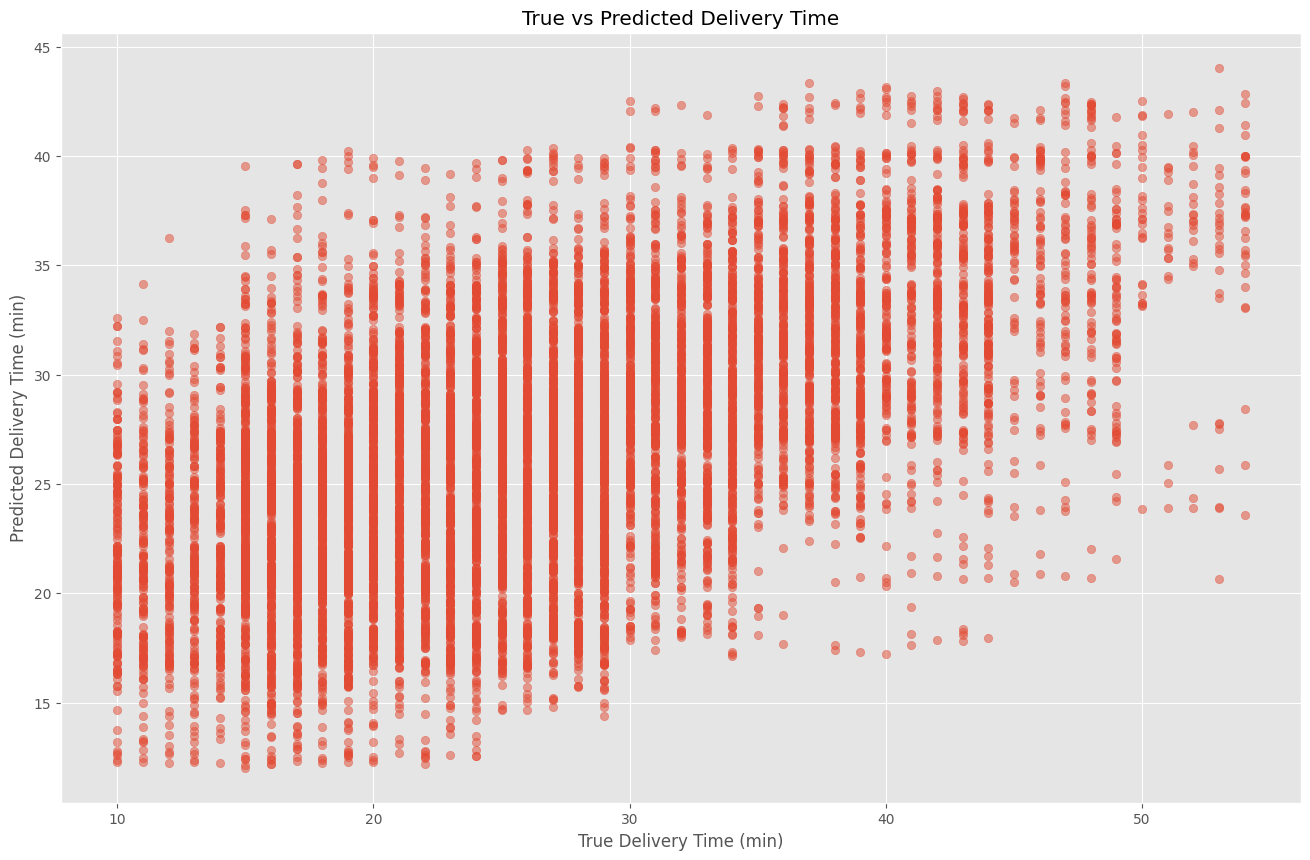

(12243,) (12243,)


In [ ]:
# Sample posterior predictive
predictive = pyro.infer.Predictive(model2.model, guide=guide, num_samples=1000,
                                   return_sites=("y","d"))

samples = predictive(X2_test_torch[:,:-2], vehicle_type=X2_test_torch[:,-2].long(), city_type=X2_test_torch[:,-1].long())

# Get the mean prediction
y2_pred_samples = samples["y"]  # shape: [100, N]
y2_pred_mean = y2_pred_samples.mean(0).detach().numpy()

# Invert normalization
y2_pred_original = y2_pred_mean * y2_std + y2_mean
y2_true_original = (y2_test * y2_std + y2_mean).flatten()

# Scatter plot
plt.scatter(y2_true_original, y2_pred_original, alpha=0.5)
plt.xlabel("True Delivery Time (min)")
plt.ylabel("Predicted Delivery Time (min)")
plt.title("True vs Predicted Delivery Time")
plt.show()

print(y2_pred_original.shape,y2_true_original.shape)

Analysis

In [ ]:
corr, mae, rae, rmse, r2 = compute_error(y2_true_original, y2_pred_original)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.562
MAE: 6.286
RMSE: 7.771
R2: 0.308


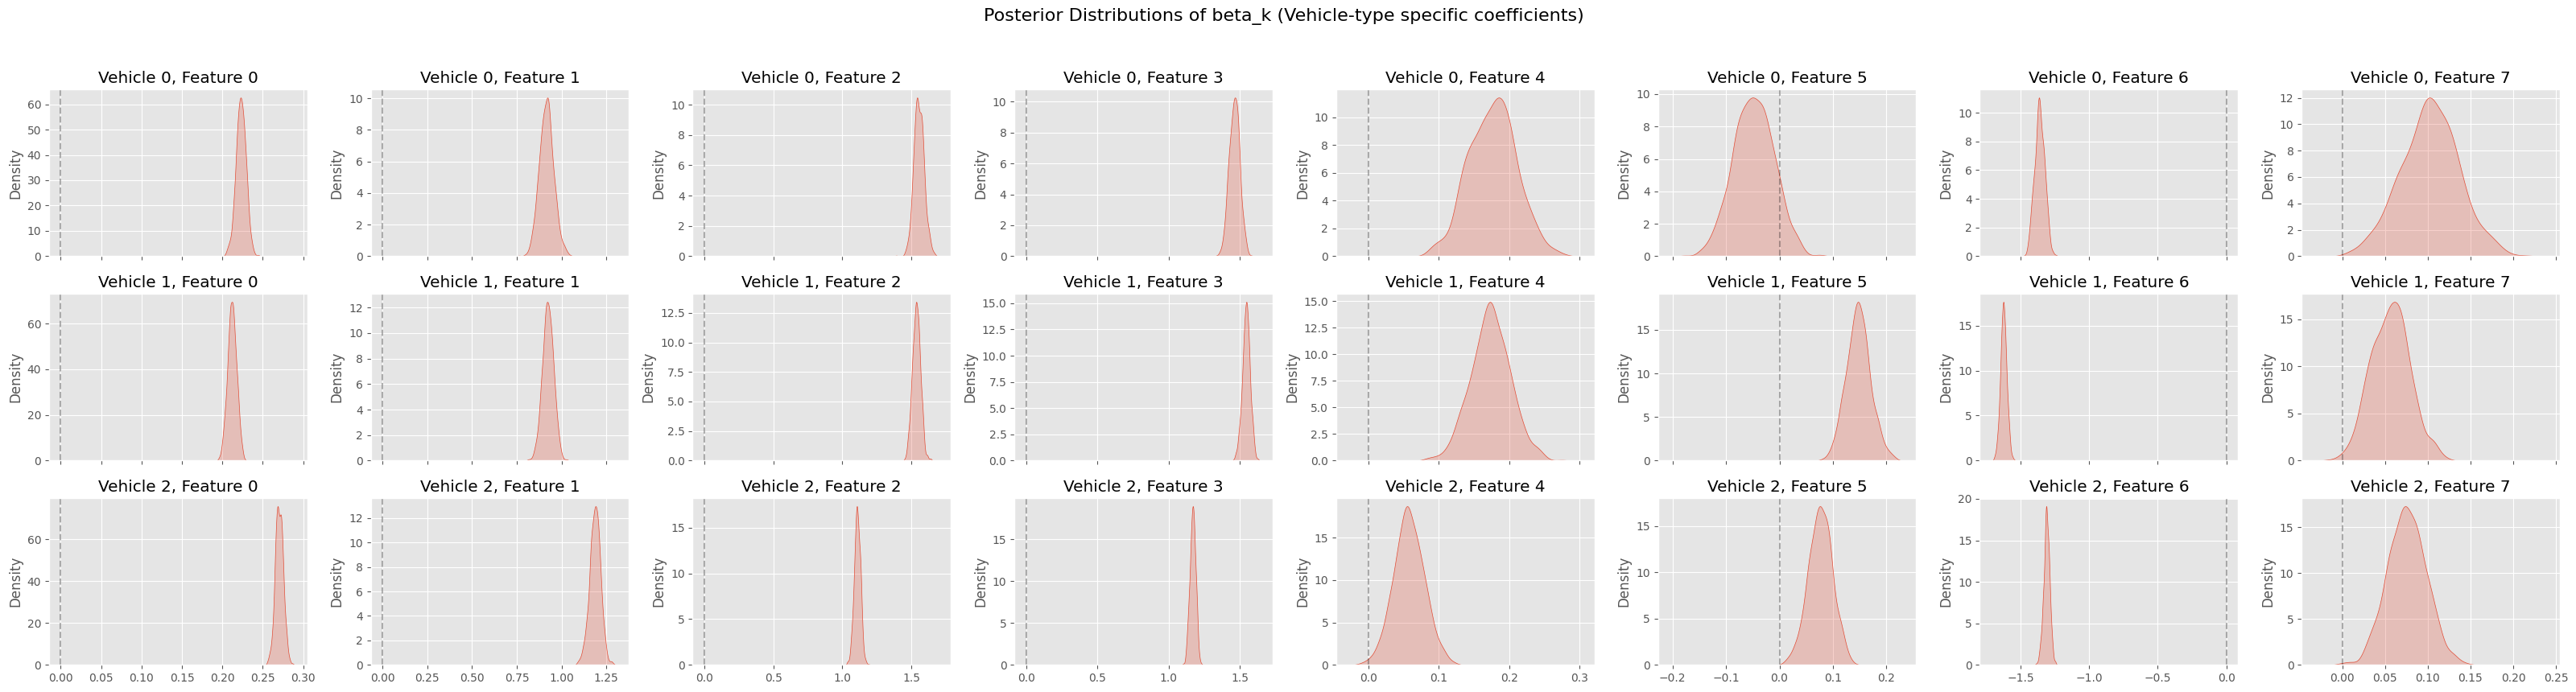

In [ ]:
posterior = pyro.infer.Predictive(
    model2.model,
    guide=guide,
    num_samples=1000,
    return_sites=("beta_k",)
)
posterior_samples = posterior(X2_test_torch[:,:-2], X2_test_torch[:,-2].long(), X2_test_torch[:,-1].long())
beta_k_samples = posterior_samples["beta_k"]  # shape: [1000, K, D]

import seaborn as sns

num_vehicle_types = K  # 3
num_features = D

fig, axes = plt.subplots(num_vehicle_types, num_features, figsize=(4*num_features, 3*num_vehicle_types), sharex='col')
fig.suptitle("Posterior Distributions of beta_k (Vehicle-type specific coefficients)", fontsize=16)

for k in range(num_vehicle_types):
    for d in range(num_features):
        ax = axes[k, d] if num_vehicle_types > 1 else axes[d]
        sns.kdeplot(beta_k_samples[:, k, d].detach().numpy(), ax=ax, fill=True)
        ax.set_title(f"Vehicle {k}, Feature {d}")
        ax.axvline(0, color="k", linestyle="--", alpha=0.3)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#Part 6: Contributions

## Contributions for the explanatory notebook

| **Section**                         | **Contributor**                   |
|------------------------------------|------------------------------------|
| Motivation                         | Giovanni Fassoni (s242942), Ulrik Longva Haugland (s241658)                   |
| Data Exploration                   | Matteo D'Souza (s242947)           |
| Bayesian Linear Regression         | Matteo D'Souza (s242947)           |
| Probabilistic Graphical Model      | Florian Schwill(s250424)                 |
| Hierarchical Modeling              | Florian Schwill (s250424)                                 |
| References                         | Matteo D'Souza (s242947)           |



## Contribution for the final report
| **Section**                         | **Contributor**                   |
|------------------------------------|------------------------------------|
| Introduction                         | Giovanni Fassoni(s242942)                  |
| Methods                  | Ulrik Longva Haugland(s241658)         |
|Methods (only SVI)                  | Matteo D'Souza(s242947)         |                  | Ulrik Longva Haugland(s241658)         |
| Results    | Giovanni Fassoni (s242942)     |
| Discussion      |Ulrik Longva Haugland(s241658)                 |



#Part 7: References

<a id="ref1"></a>1. https://docs.pyro.ai/en/dev/_modules/pyro/infer/trace_elbo.html
